# Coastal Ocean Wave Height Assessment


This notebook is a follow-up from the [Sea Surface Height notebook](http://ioos.github.io/notebooks_demos/notebooks/2018-03-15-ssh-skillscore), here we use the same workflow to compare observations and models for sea waves height.

We start with virtually the same configuration from before, except that now we changed the variable names to "waves" and the corresponding `standard_names` for waves.

For more information regarding the workflow presented here see [SSH notebook](http://ioos.github.io/notebooks_demos/notebooks/2018-03-15-ssh-skillscore) and [Signell, Richard P.; Fernandes, Filipe; Wilcox, Kyle.   2016. "Dynamic Reusable Workflows for Ocean Science." *J. Mar. Sci. Eng.* 4, no. 4: 68](http://dx.doi.org/10.3390/jmse4040068).

In [1]:
import warnings

# Suppresing warnings for a "pretty output."
warnings.simplefilter('ignore')

In [2]:
%%writefile wave_config.yaml

date:
    start: 2018-2-28 00:00:00
    stop:  2018-3-10 00:00:00

run_name: 'latest'

region:
    bbox: [-71.20, 41.40, -69.20, 43.74]
    crs: 'urn:ogc:def:crs:OGC:1.3:CRS84'

sos_name: 'waves'

cf_names:
    - sea_surface_wave_significant_height
    - sea_surface_wind_wave_significant_height

units: 'm'

catalogs:
    - https://data.ioos.us/csw

Overwriting wave_config.yaml


In [3]:
import os
import shutil
from datetime import datetime
from ioos_tools.ioos import parse_config

config = parse_config('wave_config.yaml')

save_dir = os.path.abspath(config['run_name'])
if os.path.exists(save_dir):
    shutil.rmtree(save_dir)
os.makedirs(save_dir)

fmt = '{:*^64}'.format
print(fmt('Saving data inside directory {}'.format(save_dir)))
print(fmt(' Run information '))
print('Run date: {:%Y-%m-%d %H:%M:%S}'.format(datetime.utcnow()))
print('Start: {:%Y-%m-%d %H:%M:%S}'.format(config['date']['start']))
print('Stop: {:%Y-%m-%d %H:%M:%S}'.format(config['date']['stop']))
print('Bounding box: {0:3.2f}, {1:3.2f},'
      '{2:3.2f}, {3:3.2f}'.format(*config['region']['bbox']))

Saving data inside directory /home/filipe/IOOS/notebooks_demos/notebooks/latest
*********************** Run information ************************
Run date: 2018-03-12 13:08:47
Start: 2018-02-28 00:00:00
Stop: 2018-03-10 00:00:00
Bounding box: -71.20, 41.40,-69.20, 43.74


In [4]:
def make_filter(config):
    from owslib import fes
    from ioos_tools.ioos import fes_date_filter
    kw = dict(wildCard='*', escapeChar='\\',
              singleChar='?', propertyname='apiso:Subject')

    if len(config['cf_names']) > 1:
        or_filt = fes.Or([fes.PropertyIsLike(literal=('*%s*' % val), **kw)
                      for val in config['cf_names']])
    else:
        or_filt = fes.PropertyIsLike(literal=('*%s*' % config['cf_names'][0]), **kw)      

    not_filt = fes.Not([fes.PropertyIsLike(literal='GRIB-2', **kw)])

    begin, end = fes_date_filter(config['date']['start'],
                                 config['date']['stop'])
    bbox_crs = fes.BBox(config['region']['bbox'],
                        crs=config['region']['crs'])
    filter_list = [fes.And([bbox_crs, begin, end, or_filt, not_filt])]
    return filter_list


filter_list = make_filter(config)

In [5]:
from ioos_tools.ioos import service_urls, get_csw_records
from owslib.csw import CatalogueServiceWeb


dap_urls = []
print(fmt(' Catalog information '))
for endpoint in config['catalogs']:
    print('URL: {}'.format(endpoint))
    try:
        csw = CatalogueServiceWeb(endpoint, timeout=120)
    except Exception as e:
        print('{}'.format(e))
        continue
    csw = get_csw_records(csw, filter_list, esn='full')
    OPeNDAP = service_urls(csw.records, identifier='OPeNDAP:OPeNDAP')
    odp = service_urls(csw.records, identifier='urn:x-esri:specification:ServiceType:odp:url')
    dap = OPeNDAP + odp
    dap_urls.extend(dap)

    print('Number of datasets available: {}'.format(len(csw.records.keys())))

    for rec, item in csw.records.items():
        print('{}'.format(item.title))
    if dap:
        print(fmt(' DAP '))
        for url in dap:
            print('{}.html'.format(url))
    print('\n')

# Get only unique endpoints.
dap_urls = list(set(dap_urls))

********************* Catalog information **********************
URL: https://data.ioos.us/csw
Number of datasets available: 12
Directional wave and sea surface temperature measurements collected in situ by Datawell Mark 3 directional buoy located near LOWER COOK INLET, AK from 2016/12/16 00:00:00 to 2018/03/11 18:09:42.
NECOFS GOM3 Wave - Northeast US - Latest Forecast
BIO WW III Latest Forecasts/EastCoast.nc
BIO WW III Latest Forecasts/GulfOfMaine.nc
BIO WW III Latest Forecasts/NorthAtlantic.nc
Coupled Northwest Atlantic Prediction System (CNAPS)
Directional wave and sea surface temperature measurements collected in situ by Datawell Mark 3 directional buoy located near ASTORIA CANYON, OR from 2017/08/03 18:00:00 to 2018/03/11 17:57:11.
Directional wave and sea surface temperature measurements collected in situ by Datawell Mark 3 directional buoy located near CAPE COD BAY, MA from 2017/10/05 20:00:00 to 2018/03/11 18:01:09.
Directional wave and sea surface temperature measurements col

In [6]:
from ioos_tools.ioos import is_station

non_stations = []
for url in dap_urls:
    try:
        if not is_station(url):
            non_stations.append(url)
    except (RuntimeError, OSError, IOError) as e:
        print('Could not access URL {}. {!r}'.format(url, e))

dap_urls = non_stations

print(fmt(' Filtered DAP '))
for url in dap_urls:
    print('{}.html'.format(url))

************************* Filtered DAP *************************
http://www.neracoos.org/thredds/dodsC/WW3/GulfOfMaine.nc.html
http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_WAVE_FORECAST.nc.html
http://www.neracoos.org/thredds/dodsC/WW3/EastCoast.nc.html
http://thredds.secoora.org/thredds/dodsC/SECOORA_NCSU_CNAPS.nc.html
http://www.neracoos.org/thredds/dodsC/WW3/NorthAtlantic.nc.html


In [7]:
from pyoos.collectors.ndbc.ndbc_sos import NdbcSos

collector_ndbc = NdbcSos()

collector_ndbc.set_bbox(config['region']['bbox'])
collector_ndbc.end_time = config['date']['stop']
collector_ndbc.start_time = config['date']['start']
collector_ndbc.variables = [config['sos_name']]

ofrs = collector_ndbc.server.offerings
title = collector_ndbc.server.identification.title
print(fmt(' NDBC Collector offerings '))
print('{}: {} offerings'.format(title, len(ofrs)))

******************* NDBC Collector offerings *******************
National Data Buoy Center SOS: 1017 offerings


In [8]:
import pandas as pd
from ioos_tools.ioos import collector2table

ndbc = collector2table(
    collector=collector_ndbc,
    config=config,
    col='sea_surface_wave_significant_height (m)'
)

if ndbc:
    data = dict(
        station_name=[s._metadata.get('station_name') for s in ndbc],
        station_code=[s._metadata.get('station_code') for s in ndbc],
        sensor=[s._metadata.get('sensor') for s in ndbc],
        lon=[s._metadata.get('lon') for s in ndbc],
        lat=[s._metadata.get('lat') for s in ndbc],
        depth=[s._metadata.get('depth') for s in ndbc],
    )

table = pd.DataFrame(data).set_index('station_code')
table

,depth,lat,lon,sensor,station_name
station_code,,,,,
44007,None,43.525,-70.141,urn:ioos:sensor:wmo:44007::wpm1,"PORTLAND - 12 NM Southeast of Portland,ME"
44013,None,42.346,-70.651,urn:ioos:sensor:wmo:44013::wpm1,"BOSTON 16 NM East of Boston, MA"
44020,None,41.439,-70.186,urn:ioos:sensor:wmo:44020::wpm1,NANTUCKET SOUND
44029,None,42.523,-70.566,urn:ioos:sensor:wmo:44029::summarywav1,Buoy A01 - Massachusetts Bay
44030,None,43.181,-70.428,urn:ioos:sensor:wmo:44030::summarywav1,Buoy B01 - Western Maine Shelf
44032,None,43.716,-69.355,urn:ioos:sensor:wmo:44032::summarywav1,Buoy E01 - Central Maine Shelf
44090,None,41.840,-70.329,urn:ioos:sensor:wmo:44090::summarywav1,"Cape Cod Bay, MA (221)"
44098,None,42.798,-70.168,urn:ioos:sensor:wmo:44098::summarywav1,"Jeffrey's Ledge, NH (160)"


In [9]:
data = ndbc

index = pd.date_range(
    start=config['date']['start'].replace(tzinfo=None),
    end=config['date']['stop'].replace(tzinfo=None),
    freq='1H'
)

# Preserve metadata with `reindex`.
observations = []
for series in data:
    _metadata = series._metadata
    obs = series.reindex(index=index, limit=1, method='nearest')
    obs._metadata = _metadata
    # FIXME: remove this!
    obs._metadata['standard_name']='sea_surface_wave_significant_height'

    observations.append(obs)

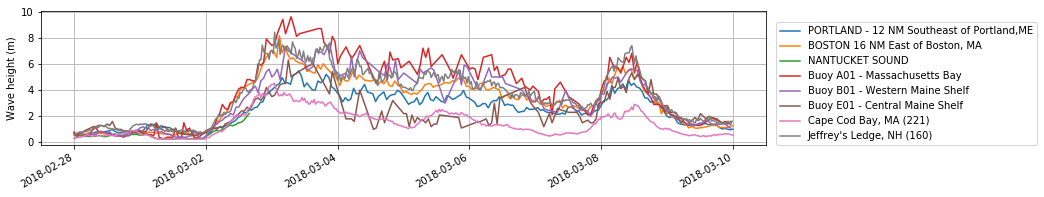

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(13, 2.75))
for series in data:
    series.plot(ax=ax, label=series._metadata['station_name'])
    plt.legend(bbox_to_anchor=(1.38, 0.95), loc='upper right')
    ax.grid(True)
    ax.set_ylabel('Wave height (m)')
    ax.set_xlabel('')

In [11]:
import iris
from ioos_tools.tardis import series2cube

attr = dict(
    featureType='timeSeries',
    Conventions='CF-1.6',
    standard_name_vocabulary='CF-1.6',
    cdm_data_type='Station',
    comment='Data from http://opendap.co-ops.nos.noaa.gov'
)


cubes = iris.cube.CubeList(
    [series2cube(obs, attr=attr) for obs in observations]
)

outfile = os.path.join(save_dir, 'OBS_DATA.nc')
iris.save(cubes, outfile)

In [12]:
def check_standard_name(url, standard_names):
    from netCDF4 import Dataset
    standard_name = lambda v: v in standard_names

    with Dataset(url) as nc:
        variables = nc.get_variables_by_attributes(standard_name=standard_name)
    if variables:
        return True
    else:
        return False

In [13]:
from iris.exceptions import (CoordinateNotFoundError, ConstraintMismatchError,
                             MergeError)
from ioos_tools.ioos import get_model_name
from ioos_tools.tardis import quick_load_cubes, proc_cube, is_model, get_surface

print(fmt(' Models '))
cubes = dict()
for k, url in enumerate(dap_urls):
    print('\n[Reading url {}/{}]: {}'.format(k+1, len(dap_urls), url))
    if not check_standard_name(url, config['cf_names']):
        print('Could not find {} in {}'.format(config['cf_names'], url))
        continue
    try:
        cube = quick_load_cubes(url, config['cf_names'],
                                callback=None, strict=True)
        if is_model(cube):
            cube = proc_cube(cube,
                             bbox=config['region']['bbox'],
                             time=(config['date']['start'],
                                   config['date']['stop']),
                             units=config['units'])
        else:
            print('[Not model data]: {}'.format(url))
            continue
        mod_name = get_model_name(url)
        cubes.update({mod_name: cube})
    except (RuntimeError, ValueError,
            ConstraintMismatchError, CoordinateNotFoundError,
            IndexError) as e:
        print('Cannot get cube for: {}\n{}'.format(url, e))

**************************** Models ****************************

[Reading url 1/5]: http://www.neracoos.org/thredds/dodsC/WW3/GulfOfMaine.nc

[Reading url 2/5]: http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_WAVE_FORECAST.nc

[Reading url 3/5]: http://www.neracoos.org/thredds/dodsC/WW3/EastCoast.nc

[Reading url 4/5]: http://thredds.secoora.org/thredds/dodsC/SECOORA_NCSU_CNAPS.nc

[Reading url 5/5]: http://www.neracoos.org/thredds/dodsC/WW3/NorthAtlantic.nc


In [14]:
import iris
from iris.pandas import as_series
from ioos_tools.tardis import (make_tree, get_nearest_water,
                               add_station, ensure_timeseries, remove_ssh)

for mod_name, cube in cubes.items():
    fname = '{}.nc'.format(mod_name)
    fname = os.path.join(save_dir, fname)
    print(fmt(' Downloading to file {} '.format(fname)))
    try:
        tree, lon, lat = make_tree(cube)
    except CoordinateNotFoundError as e:
        print('Cannot make KDTree for: {}'.format(mod_name))
        continue
    # Get model series at observed locations.
    raw_series = dict()
    for obs in observations:
        obs = obs._metadata
        station = obs['station_code']
        try:
            kw = dict(k=10, max_dist=0.08, min_var=0.01)
            args = cube, tree, obs['lon'], obs['lat']
            try:
                series, dist, idx = get_nearest_water(*args, **kw)
            except RuntimeError as e:
                print('Cannot download {!r}.\n{}'.format(cube, e))
                series = None
        except ValueError as e:
            status = 'No Data'
            print('[{}] {}'.format(status, obs['station_name']))
            continue
        if not series:
            status = 'Land   '
        else:
            raw_series.update({station: series})
            series = as_series(series)
            status = 'Water  '
        print('[{}] {}'.format(status, obs['station_name']))
    if raw_series:  # Save cube.
        for station, cube in raw_series.items():
            cube = add_station(cube, station)
        try:
            cube = iris.cube.CubeList(raw_series.values()).merge_cube()
        except MergeError as e:
            print(e)
        ensure_timeseries(cube)
        try:
            iris.save(cube, fname)
        except AttributeError:
            # FIXME: we should patch the bad attribute instead of removing everything.
            cube.attributes = {}
            iris.save(cube, fname)
        del cube
    print('Finished processing [{}]'.format(mod_name))

[Water  ] PORTLAND - 12 NM Southeast of Portland,ME
[Water  ] BOSTON 16 NM East of Boston, MA
[Water  ] NANTUCKET SOUND
[Water  ] Buoy A01 - Massachusetts Bay
[Water  ] Buoy B01 - Western Maine Shelf
[Water  ] Buoy E01 - Central Maine Shelf
[Water  ] Cape Cod Bay, MA (221)
[Water  ] Jeffrey's Ledge, NH (160)
Finished processing [WW3-GulfOfMaine]
[Water  ] PORTLAND - 12 NM Southeast of Portland,ME
[Water  ] BOSTON 16 NM East of Boston, MA
[Water  ] NANTUCKET SOUND
[Water  ] Buoy A01 - Massachusetts Bay
[Water  ] Buoy B01 - Western Maine Shelf
[Water  ] Buoy E01 - Central Maine Shelf
[Water  ] Cape Cod Bay, MA (221)
[Water  ] Jeffrey's Ledge, NH (160)
Finished processing [FVCOM_Forecasts-NECOFS_WAVE_FORECAST]
[Water  ] PORTLAND - 12 NM Southeast of Portland,ME
[Water  ] BOSTON 16 NM East of Boston, MA
[No Data] NANTUCKET SOUND
[Water  ] Buoy A01 - Massachusetts Bay
[No Data] Buoy B01 - Western Maine Shelf
[Water  ] Buoy E01 - Central Maine Shelf
[Water  ] Cape Cod Bay, MA (221)
[No Data]

In [15]:
from ioos_tools.ioos import stations_keys


def rename_cols(df, config):
    cols = stations_keys(config, key='station_name')
    return df.rename(columns=cols)

In [16]:
from ioos_tools.ioos import load_ncs
from ioos_tools.skill_score import mean_bias, apply_skill

dfs = load_ncs(config)

df = apply_skill(dfs, mean_bias, remove_mean=False, filter_tides=False)
skill_score = dict(mean_bias=df.to_dict())

# Filter out stations with no valid comparison.
df.dropna(how='all', axis=1, inplace=True)
df = df.applymap('{:.2f}'.format).replace('nan', '--')

In [17]:
from ioos_tools.skill_score import rmse

dfs = load_ncs(config)

df = apply_skill(dfs, rmse, remove_mean=True, filter_tides=False)
skill_score['rmse'] = df.to_dict()

# Filter out stations with no valid comparison.
df.dropna(how='all', axis=1, inplace=True)
df = df.applymap('{:.2f}'.format).replace('nan', '--')

In [18]:
import pandas as pd

# Stringfy keys.
for key in skill_score.keys():
    skill_score[key] = {str(k): v for k, v in skill_score[key].items()}

mean_bias = pd.DataFrame.from_dict(skill_score['mean_bias'])
mean_bias = mean_bias.applymap('{:.2f}'.format).replace('nan', '--')

skill_score = pd.DataFrame.from_dict(skill_score['rmse'])
skill_score = skill_score.applymap('{:.2f}'.format).replace('nan', '--')

In [19]:
import folium
from ioos_tools.ioos import get_coordinates


def make_map(bbox, **kw):
    line = kw.pop('line', True)
    layers = kw.pop('layers', True)
    zoom_start = kw.pop('zoom_start', 5)

    lon = (bbox[0] + bbox[2]) / 2
    lat = (bbox[1] + bbox[3]) / 2
    m = folium.Map(width='100%', height='100%',
                   location=[lat, lon], zoom_start=zoom_start)

    if layers:
        url = 'http://geoport-dev.whoi.edu/thredds/wms/coawst_4/use/fmrc/coawst_4_use_best.ncd'
        w = folium.WmsTileLayer(url, name='COAWST Wave Height', fmt='image/png', layers='Hwave',
            style='boxfill/rainbow', COLORSCALERANGE='0,5', overlay=True, transparent=True)

        w.add_to(m)

    if line:
        p = folium.PolyLine(get_coordinates(bbox), color='#FF0000', weight=2, opacity=0.9, latlon=True)
        p.add_to(m)
    return m

In [20]:
bbox = config['region']['bbox']

m = make_map(
    bbox,
    zoom_start=9,
    line=True,
    layers=True
)

In [21]:
all_obs = stations_keys(config)

from glob import glob
from operator import itemgetter

import iris
from folium.plugins import MarkerCluster

iris.FUTURE.netcdf_promote = True

big_list = []
for fname in glob(os.path.join(save_dir, '*.nc')):
    if 'OBS_DATA' in fname:
        continue
    cube = iris.load_cube(fname)
    model = os.path.split(fname)[1].split('-')[-1].split('.')[0]
    lons = cube.coord(axis='X').points
    lats = cube.coord(axis='Y').points
    stations = cube.coord('station_code').points
    models = [model]*lons.size
    lista = zip(models, lons.tolist(), lats.tolist(), stations.tolist())
    big_list.extend(lista)

big_list.sort(key=itemgetter(3))
df = pd.DataFrame(big_list, columns=['name', 'lon', 'lat', 'station'])
df.set_index('station', drop=True, inplace=True)
groups = df.groupby(df.index)


locations, popups = [], []
for station, info in groups:
    sta_name = all_obs[station].replace("'","")
    for lat, lon, name in zip(info.lat, info.lon, info.name):
        locations.append([lat, lon])
        popups.append('[{}]: {}'.format(name, sta_name))

MarkerCluster(locations=locations, popups=popups, name='Cluster').add_to(m);

In [22]:
# Some known models names. Unknonwn models will use the title metadata or the URL.
titles = {
    'coawst_4_use_best': 'COAWST_4',
    'global': 'HYCOM',
    'NECOFS_GOM3_FORECAST': 'NECOFS_GOM3',
    'NECOFS_FVCOM_OCEAN_MASSBAY_FORECAST': 'NECOFS_MassBay',
    'OBS_DATA': 'Observations'
}

In [23]:
from bokeh.resources import CDN
from bokeh.plotting import figure
from bokeh.embed import file_html
from bokeh.models import HoverTool, Legend
from itertools import cycle
from bokeh.palettes import Category20

from folium import IFrame

# Plot defaults.
colors = Category20[20]
colorcycler = cycle(colors)
tools = 'pan,box_zoom,reset'
width, height = 750, 250


def make_plot(df, station):
    p = figure(
        toolbar_location='above',
        x_axis_type='datetime',
        width=width,
        height=height,
        tools=tools,
        title=str(station)
    )
    leg = []
    for column, series in df.iteritems():
        series.dropna(inplace=True)
        if not series.empty:
            if 'OBS_DATA' not in column:
                bias = mean_bias[str(station)][column]
                skill = skill_score[str(station)][column]
                line_color = next(colorcycler)
                kw = dict(alpha=0.65, line_color=line_color)
            else:
                skill = bias = 'NA'
                kw = dict(alpha=1, color='crimson')
            line = p.line(
                x=series.index,
                y=series.values,
                line_width=5,
                line_cap='round',
                line_join='round',
                **kw
            )
            leg.append(('{}'.format(titles.get(column, column)), [line]))
            p.add_tools(HoverTool(tooltips=[('Name', '{}'.format(titles.get(column, column))),
                                            ('Bias', bias),
                                            ('Skill', skill)],
                                  renderers=[line]))
    legend = Legend(items=leg, location=(0, 60))
    legend.click_policy = 'mute'
    p.add_layout(legend, 'right')
    p.yaxis[0].axis_label = 'Wave Height (m)'
    p.xaxis[0].axis_label = 'Date/time'
    return p


def make_marker(p, station):
    lons = stations_keys(config, key='lon')
    lats = stations_keys(config, key='lat')

    lon, lat = lons[station], lats[station]
    html = file_html(p, CDN, station)
    iframe = IFrame(html, width=width+40, height=height+80)

    popup = folium.Popup(iframe, max_width=2650)
    icon = folium.Icon(color='green', icon='stats')
    marker = folium.Marker(location=[lat, lon],
                           popup=popup,
                           icon=icon)
    return marker

In [24]:
dfs = load_ncs(config)

for station in dfs:
    sta_name = all_obs[station].replace("'","")
    df = dfs[station]
    if df.empty:
        continue
    p = make_plot(df, station)
    marker = make_marker(p, station)
    marker.add_to(m)

folium.LayerControl().add_to(m)

m

We can observe a noteworthy increase in the significant wave height starting February 2nd and peaking around March 3rd and followed but a second smaller peak after March 8th.